In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
cust_db = pd.read_csv("001_lomo_customers_dataset.csv", encoding = "utf-8-sig")
sel_db = pd.read_csv("002_lomo_sellers_dataset.csv", encoding = "utf-8-sig")
geoloc_db = pd.read_csv("003_lomo_geolocation_dataset.csv", encoding = "utf-8-sig")
prod_db = pd.read_csv("004_lomo_products_dataset.csv", encoding = "utf-8-sig")
category_trans_db = pd.read_csv("005_lomo_product_category_name_translation.csv", encoding="utf-8-sig")
orders_db = pd.read_csv("006_lomo_orders_dataset.csv", encoding = "utf-8-sig")
items_db = pd.read_csv("007_lomo_order_items_dataset.csv", encoding = "utf-8-sig")
payments_db = pd.read_csv("008_lomo_order_payments_dataset.csv", encoding = "utf-8-sig")
reviews_db = pd.read_csv("009_lomo_order_reviews_dataset.csv", encoding = "utf-8-sig")
market_db = pd.read_csv("010_lomo_marketing_qualified_leads_dataset.csv", encoding = "utf-8-sig")
deals_db = pd.read_csv("011_lomo_closed_deals_dataset.csv", encoding = "utf-8-sig")

In [86]:
for name, df in {
    "cust_db": cust_db, "sel_db": sel_db, "geoloc_db": geoloc_db,
    "prod_db": prod_db, "category_trans_db": category_trans_db,
    "orders_db": orders_db, "items_db": items_db, "payments_db": payments_db,
    "reviews_db": reviews_db, "market_db": market_db, "deals_db": deals_db
}.items():
    print(f"\n{name}.info():"); df.info()


cust_db.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  object
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: object(5)
memory usage: 3.8+ MB

sel_db.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   seller_id                    3095 non-null   object
 1   seller_zip_code_prefix_prep  3095 non-null   object
 2   seller_city_prep             3095 non-null   object
 3   seller_state_prep            3095 non-null   

## Which product category has the best performance?

In [87]:
# best performance

# first translate category (just for convenience)
translation_dict = dict(zip(
    category_trans_db['product_category_name_portugese'], 
    category_trans_db['product_category_name_english']
))

prod_db['product_category_name'] = prod_db['product_category_name'].replace(translation_dict)

prod_db['product_label'] = ['Product ' + str(i) for i in range(len(prod_db))]

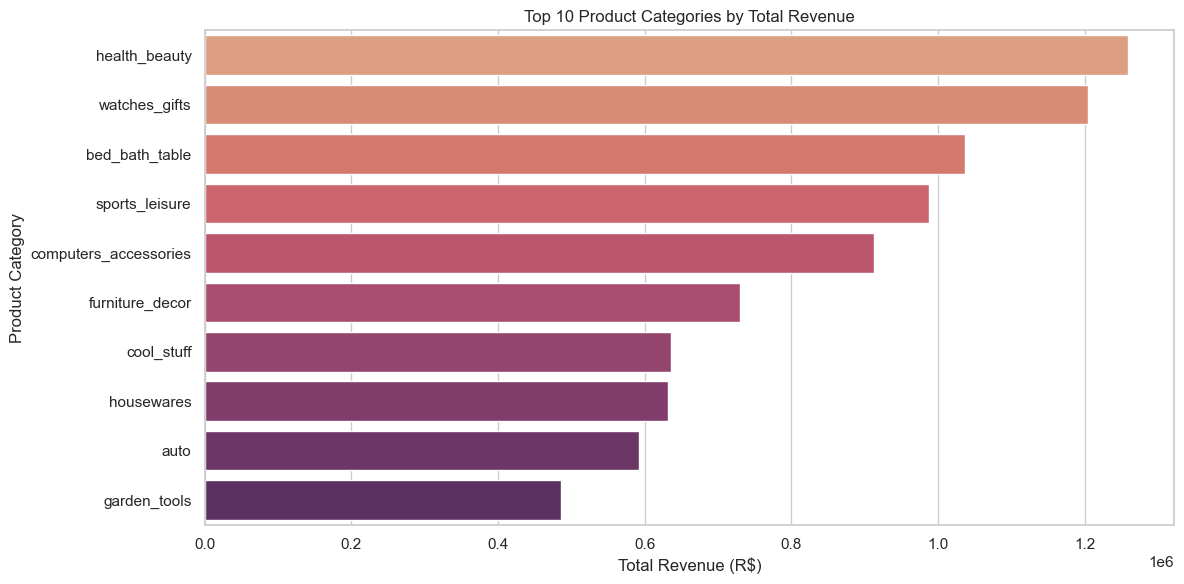

In [88]:
# merge product and items
prod_items = pd.merge(items_db, prod_db, on='product_id', how='left')

# aggregate
performance = prod_items.groupby('product_category_name').agg(
    total_revenue=('price', 'sum'),
    total_units_sold=('product_id', 'count'),
    avg_price=('price', 'mean')
).sort_values(by='total_revenue', ascending=False).reset_index()

# top 10 product categories by revenue
top_perf = performance.head(10)

#print(top_perf)

# plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_perf, x='total_revenue', y='product_category_name', palette='flare')
plt.title("Top 10 Product Categories by Total Revenue")
plt.xlabel("Total Revenue (R$)")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()

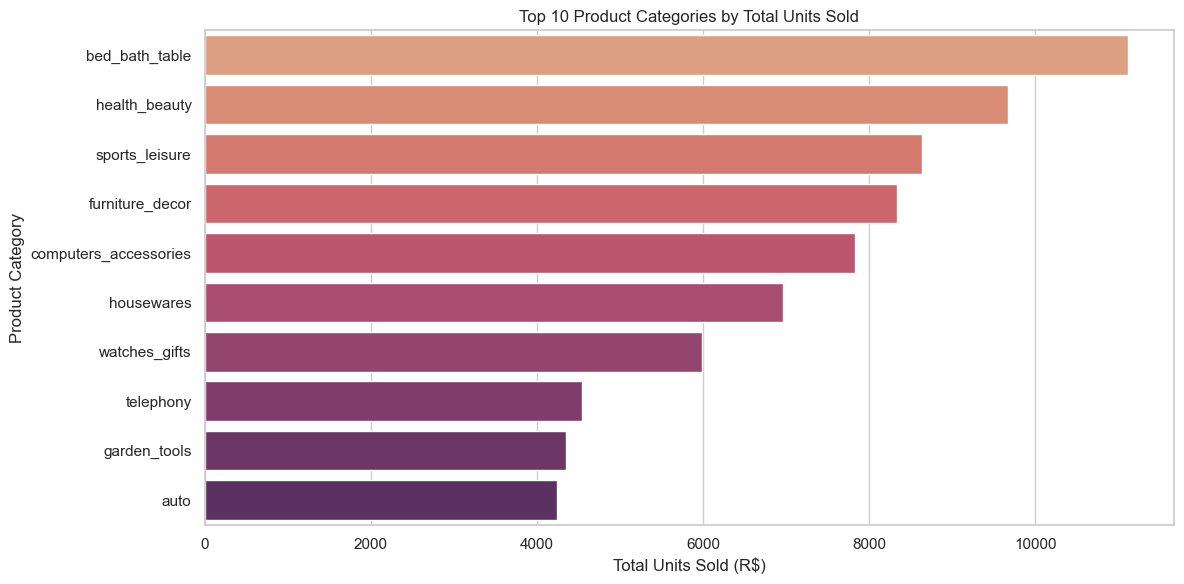

In [89]:
# top 10 product categories by units sold
#print(performance.sort_values(by='total_units_sold', ascending=False).head(10))
top_perf = performance.sort_values(by='total_units_sold', ascending=False).reset_index().head(10)
# plot

plt.figure(figsize=(12, 6))
sns.barplot(data=top_perf, x='total_units_sold', y='product_category_name', palette='flare')
plt.title("Top 10 Product Categories by Total Units Sold")
plt.xlabel("Total Units Sold (R$)")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()

       customer_state  total_revenue
45             Roi Et      464967.52
26  Nakhon Ratchasima      428087.17
47       Sakon Nakhon      360135.79
53          Si Sa Ket      344784.33
21      Maha Sarakham      301961.92
63   Ubon Ratchathani      287115.81
25      Nakhon Phanom      287050.24
12            Kalasin      275431.99
59              Surin      266946.26
5        Chachoengsao      265537.56


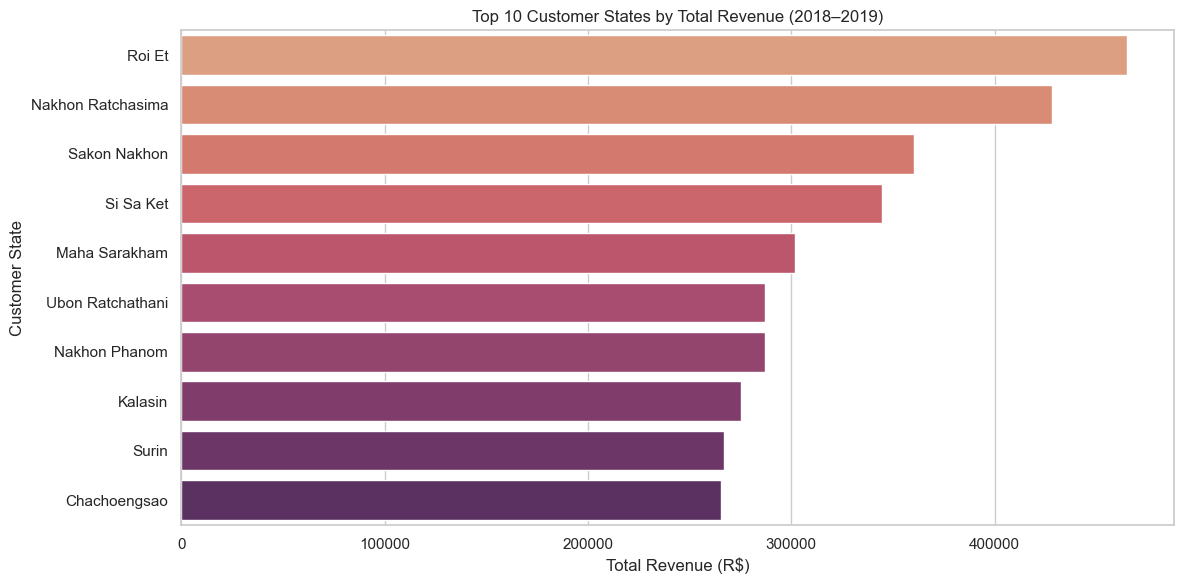

In [90]:
# top paying states 2018 to 2019 only
orders_db['order_purchase_timestamp'] = pd.to_datetime(orders_db['order_purchase_timestamp'])
orders_filtered = orders_db[
    (orders_db['order_purchase_timestamp'] >= '2018-01-01') &
    (orders_db['order_purchase_timestamp'] <= '2020-01-01')
]

# merge data
order_merged_filtered = (
    orders_filtered[['order_id', 'customer_id']]
    .merge(items_db[['order_id', 'product_id', 'price']], on='order_id', how='left')
    .merge(prod_db[['product_id', 'product_category_name']], on='product_id', how='left')
    .merge(cust_db[['customer_id', 'customer_state']], on='customer_id', how='left')
)

# group by customer state
revenue_by_state = (
    order_merged_filtered.groupby('customer_state')['price']
    .sum()
    .reset_index(name='total_revenue')
    .sort_values(by='total_revenue', ascending=False)
)

print(revenue_by_state.head(10))

# plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=revenue_by_state.head(10), 
    x='total_revenue', 
    y='customer_state', 
    palette='flare'
)
plt.title("Top 10 Customer States by Total Revenue (2018–2019)")
plt.xlabel("Total Revenue (R$)")
plt.ylabel("Customer State")
plt.tight_layout()
plt.show()


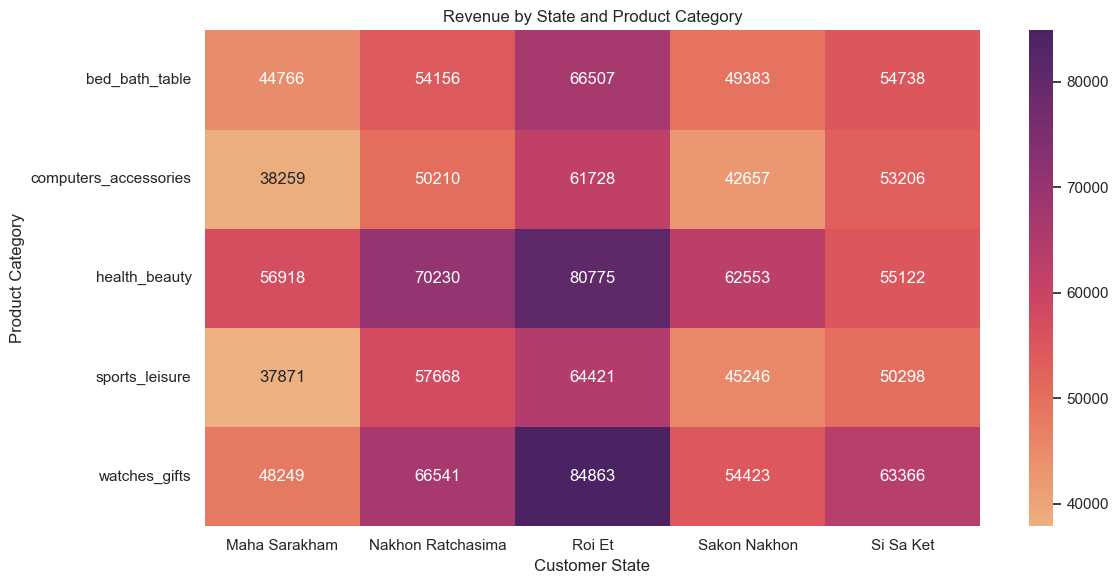

In [91]:
# break down by state and category
order_merged_df = (
    orders_db[['order_id', 'customer_id']]
    .merge(items_db[['order_id', 'product_id', 'price']], on='order_id', how='left')
    .merge(prod_db[['product_id', 'product_category_name']], on='product_id', how='left')
    .merge(cust_db[['customer_id', 'customer_state']], on='customer_id', how='left')
)

rev_state_cat = (
    order_merged_df.groupby(['customer_state', 'product_category_name'])['price']
    .sum()
    .reset_index(name='revenue')
    .sort_values(by='revenue', ascending=False)
)

#print(rev_state_cat.head(10))
# top 5 combinations of state + category
top_states = (
    rev_state_cat.groupby('customer_state')['revenue']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

top_cats = (
    rev_state_cat.groupby('product_category_name')['revenue']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

heatmap_data = rev_state_cat[
    rev_state_cat['customer_state'].isin(top_states) &
    rev_state_cat['product_category_name'].isin(top_cats)
]

pivot_table = heatmap_data.pivot_table(
    index='product_category_name', 
    columns='customer_state', 
    values='revenue', 
    fill_value=0
)

# plot 

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='flare', annot=True, fmt=".0f")
plt.title("Revenue by State and Product Category")
plt.xlabel("Customer State")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()

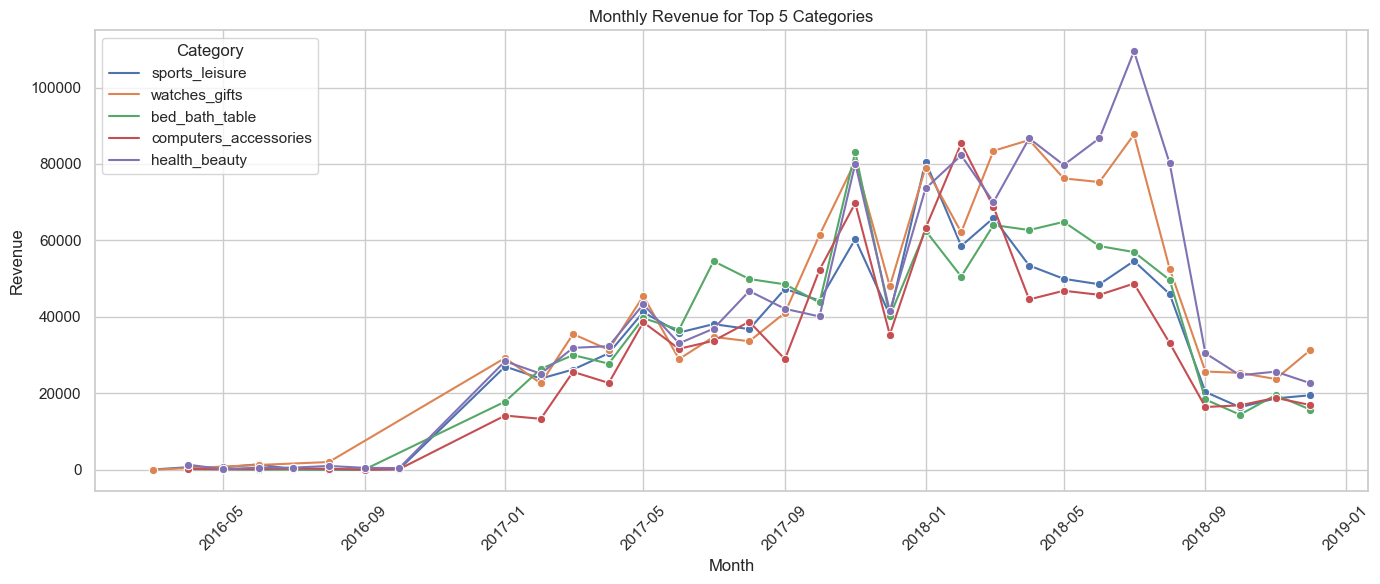

In [92]:
# merge items, product, and order timestamps
prod_items = items_db.merge(prod_db, on='product_id', how='left')
prod_items = prod_items.merge(orders_db[['order_id', 'order_purchase_timestamp']], on='order_id', how='left')

# get month
prod_items['month'] = prod_items['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()

# get top 5 product categories by total revenue
top5_cats = (
    prod_items.groupby('product_category_name')['price']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

# filter top items
top_items = prod_items[prod_items['product_category_name'].isin(top5_cats)]

# group by month and category
monthly_cat_revenue = top_items.groupby(['month', 'product_category_name']).agg(
    total_revenue=('price', 'sum')
).reset_index()

# plot

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=monthly_cat_revenue,
    x='month',
    y='total_revenue',
    hue='product_category_name',
    marker='o'
)
plt.title('Monthly Revenue for Top 5 Categories')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.legend(title='Category')
plt.grid(True)
plt.tight_layout()
plt.show()


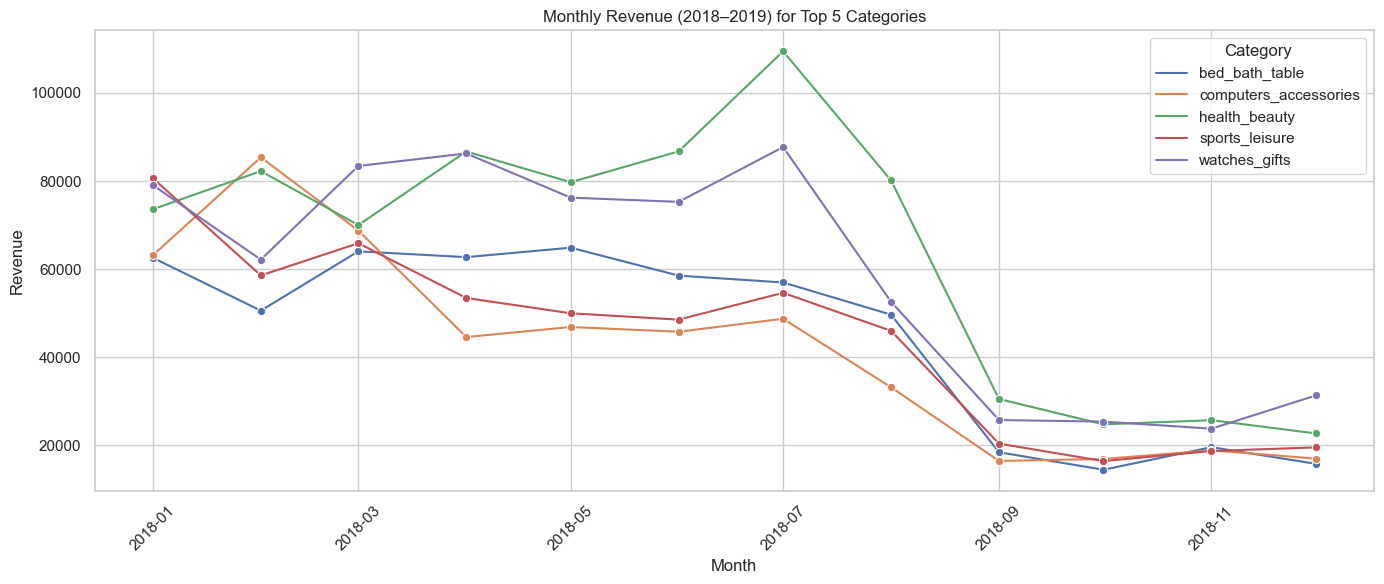

In [93]:
# 2018 and 2019 only
mask = (prod_items['order_purchase_timestamp'] >= '2018-01-01') & (prod_items['order_purchase_timestamp'] < '2020-01-01')
prod_items = prod_items[mask]

# top 5 categories by total revenue
top5_cats = (
    prod_items.groupby('product_category_name')['price']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

top_items = prod_items[prod_items['product_category_name'].isin(top5_cats)]

# group by month and category
monthly_cat_revenue = top_items.groupby(['month', 'product_category_name']).agg(
    total_revenue=('price', 'sum')
).reset_index()

# plot 
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=monthly_cat_revenue,
    x='month',
    y='total_revenue',
    hue='product_category_name',
    marker='o'
)
plt.title('Monthly Revenue (2018–2019) for Top 5 Categories')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.legend(title='Category')
plt.grid(True)
plt.tight_layout()
plt.show()


Analyzing health_beauty for the best performing, considering its strong monetary value and market traction.

### Health beauty

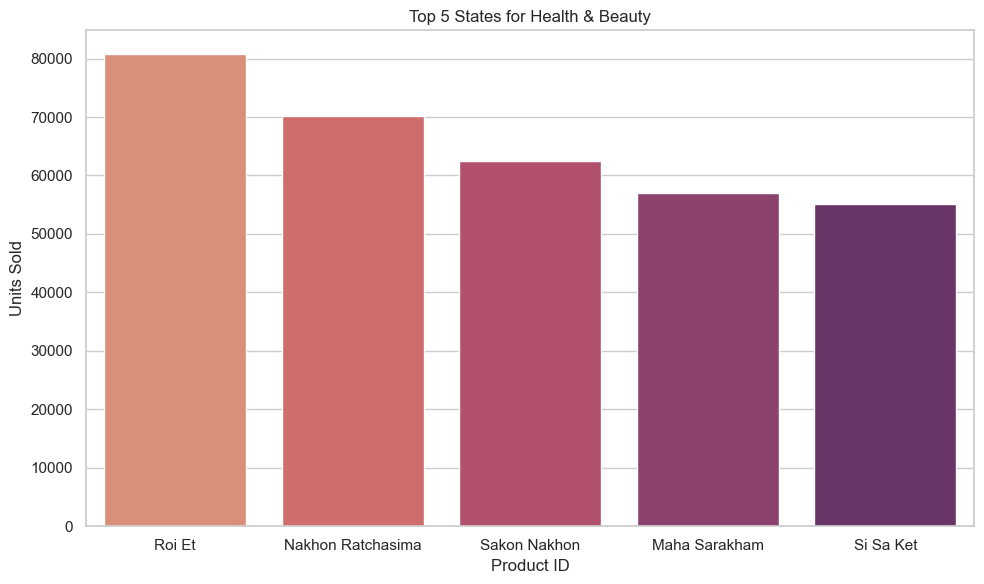

In [94]:
#top locs

# filter for health_beauty
category_df = order_merged_df[order_merged_df['product_category_name'] == 'health_beauty']

# group by state to get total revenue
revenue_by_state = (
    category_df.groupby('customer_state')['price']
    .sum()
    .reset_index(name='category_revenue')
    .sort_values(by='category_revenue', ascending=False)
)

# top 5 states for health_beauty
revenue_by_state_top = revenue_by_state.head(5)
# plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=revenue_by_state_top,
    x='customer_state',
    y='category_revenue',
    palette='flare'
)
plt.title('Top 5 States for Health & Beauty')
plt.xlabel('Product ID')
plt.ylabel('Units Sold')
plt.tight_layout()
plt.show()

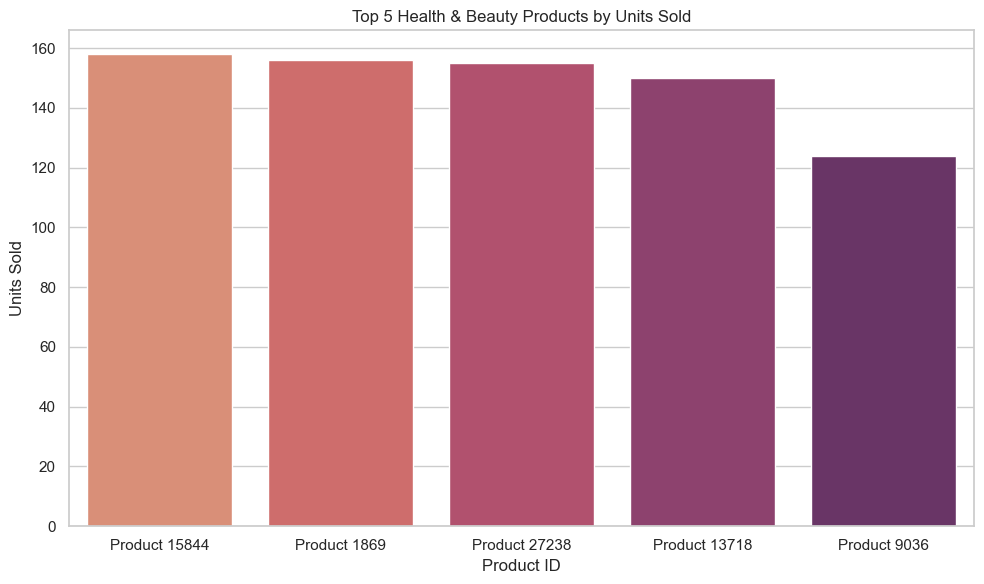

In [95]:
# filter for items
items = prod_items[prod_items['product_category_name'] == 'health_beauty']

# top products
top_products = (
    items.groupby('product_label')
    .agg(
        units_sold=('order_id', 'count'),
        total_revenue=('price', 'sum')
    )
)

# sort by units sold
top_products_sorted = top_products.sort_values(by='units_sold', ascending=False).reset_index().head(5)

# plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_products_sorted,
    x='product_label',
    y='units_sold',
    palette='flare'
)
plt.title('Top 5 Health & Beauty Products by Units Sold')
plt.xlabel('Product ID')
plt.ylabel('Units Sold')
plt.tight_layout()
plt.show()

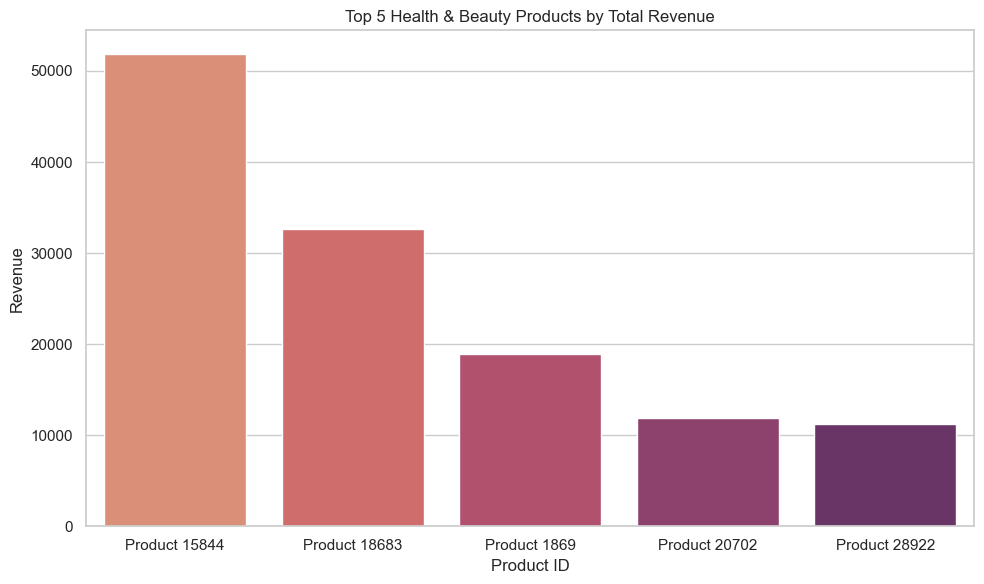

In [96]:
# filter for items
items = prod_items[prod_items['product_category_name'] == 'health_beauty']

# top products
top_products = (
    items.groupby('product_label')
    .agg(
        units_sold=('order_id', 'count'),
        total_revenue=('price', 'sum')
    )
)

# sort by units sold
top_products_sorted = top_products.sort_values(by='total_revenue', ascending=False).reset_index().head(5)

# plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_products_sorted,
    x='product_label',
    y='total_revenue',
    palette='flare'
)
plt.title('Top 5 Health & Beauty Products by Total Revenue')
plt.xlabel('Product ID')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()

In [97]:
# reviews
merged = prod_items.merge(reviews_db, on='order_id')

# filter
hb_reviews = merged[merged['product_category_name'] == 'health_beauty']

# average rating and review count
hb_reviews[['review_score']].describe()

,review_score
count,5968.000000
mean,4.133546
std,1.350478
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [98]:
hb_reviews['review_score'].value_counts().sort_index(ascending=False)

5    3643
4    1025
3     458
2     138
1     704
Name: review_score, dtype: int64

In [99]:
# convert timestamp
reviews_db['review_creation_date'] = pd.to_datetime(reviews_db['review_creation_date'])

# merge to connect reviews with products
review_orders = pd.merge(reviews_db, orders_db[['order_id', 'order_purchase_timestamp']], on='order_id', how='left')
review_items = pd.merge(review_orders, items_db[['order_id', 'product_id']], on='order_id', how='left')
review_items = pd.merge(review_items, prod_db[['product_id', 'product_category_name']], on='product_id', how='left')

# filter for h&b and 2018-2019
filtered_reviews = review_items[
    (review_items['product_category_name'] == 'health_beauty') &
    (review_items['order_purchase_timestamp'] >= '2018-01-01') &
    (review_items['order_purchase_timestamp'] < '2020-01-01')
]

# review score counts
print(filtered_reviews['review_score'].value_counts().sort_index())

# summary stats
print(filtered_reviews['review_score'].describe())


1     704
2     138
3     458
4    1025
5    3643
Name: review_score, dtype: int64
count    5968.000000
mean        4.133546
std         1.350478
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: review_score, dtype: float64


In [100]:
product_review_stats = (
    hb_reviews.groupby('product_label')
    .agg(
        avg_review_score=('review_score', 'mean'),
        review_count=('review_score', 'count'),
        total_units_sold=('order_id', 'count'),
        total_revenue=('price', 'sum')
    )
    .sort_values(by='total_revenue', ascending=False)
    .reset_index()
)

# top 10 highly-rated products
product_review_stats.head(10)


,product_label,avg_review_score,review_count,total_units_sold,total_revenue
0,Product 15844,4.276730,159,159,52185.00
1,Product 18683,4.250000,92,92,32642.00
2,Product 1869,4.076433,157,157,19012.43
3,Product 20702,3.681818,22,22,11840.30
4,Product 28922,4.150685,73,73,11181.00
5,Product 17983,4.125000,8,8,10247.20
6,Product 13718,3.840000,150,150,9862.50
7,Product 5704,4.060870,115,115,9668.67
8,Product 732,4.500000,16,16,8495.15
9,Product 25560,3.000000,6,6,8169.15


Health & Beauty stands out as the best-performing product category due to its high volume and consistent performance across key metrics. It has the highest total units sold (11,142) and generates the most revenue overall (P1.86M), indicating strong customer demand and broad market appeal. Despite having a moderate revenue per unit (P129), its ability to drive high sales volume more than compensates. Additionally, it maintains a stable review score distribution, with a healthy number of 5-star ratings, suggesting strong customer satisfaction.

# Which product category has the highest potential?

Comparing the two in the top 3 categories to each other, Watches & Gifts vs. Bed, Bath, & Table.

In [101]:
performance = (
    prod_items.groupby('product_category_name')
    .agg(
        total_units_sold=('order_id', 'count'),
        total_revenue=('price', 'sum')
    )
)

In [102]:
performance['revenue_per_unit'] = performance['total_revenue'] / performance['total_units_sold']

In [103]:
performance.loc[['watches_gifts', 'bed_bath_table', 'health_beauty']]

,total_units_sold,total_revenue,revenue_per_unit
product_category_name,,,
watches_gifts,3703,708850.94,191.426125
bed_bath_table,5884,538069.26,91.446169
health_beauty,5951,772238.15,129.766115


In [104]:
# proj revenue for watches gifts

units_sold_hb = performance.loc['health_beauty', 'total_units_sold']
revenue_per_unit_wg = performance.loc['watches_gifts', 'revenue_per_unit']

projected_revenue_wg = units_sold_hb * revenue_per_unit_wg
print(f"Projected revenue for watches_gifts with same units sold as health_beauty: {projected_revenue_wg:,.2f}")

Projected revenue for watches_gifts with same units sold as health_beauty: 1,139,176.87


In [113]:
# proj revenue for bed bath table

revenue_per_unit_bb = performance.loc['bed_bath_table', 'revenue_per_unit']

projected_revenue_bb = units_sold_hb * revenue_per_unit_bb
print(f"Projected revenue for bed_bath_table with same units sold as health_beauty: {projected_revenue_bb:,.2f}")

Projected revenue for bed_bath_table with same units sold as health_beauty: 544,196.15


In [106]:
# merge items
items_orders = pd.merge(items_db, orders_db, on='order_id', how='left')
items_orders_customers = pd.merge(items_orders, cust_db, on='customer_id', how='left')
prod_items_customers = pd.merge(items_orders_customers, prod_db, on='product_id', how='left')

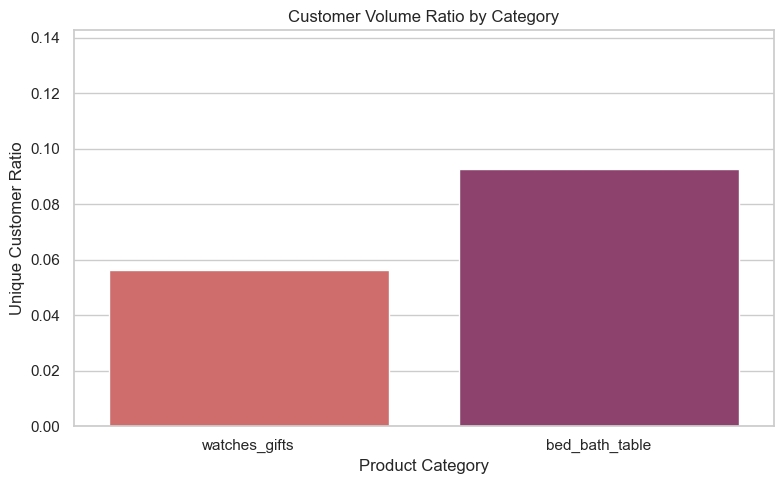

In [107]:
comparison_df = pd.DataFrame({
    'category': ['watches_gifts', 'bed_bath_table'],
    'unique_customers': [
        prod_items_customers[prod_items_customers['product_category_name'] == 'watches_gifts']['customer_unique_id'].nunique(),
        prod_items_customers[prod_items_customers['product_category_name'] == 'bed_bath_table']['customer_unique_id'].nunique()
    ]
})

# total unique customers
total_customers = prod_items_customers['customer_id'].nunique()

# ratio
comparison_df['volume_ratio'] = comparison_df['unique_customers'] / total_customers

# plot
plt.figure(figsize=(8, 5))
sns.barplot(data=comparison_df, x='category', y='volume_ratio', palette='flare')
plt.title('Customer Volume Ratio by Category')
plt.ylabel('Unique Customer Ratio')
plt.xlabel('Product Category')
plt.ylim(0, comparison_df['volume_ratio'].max() + 0.05)
plt.tight_layout()
plt.show()

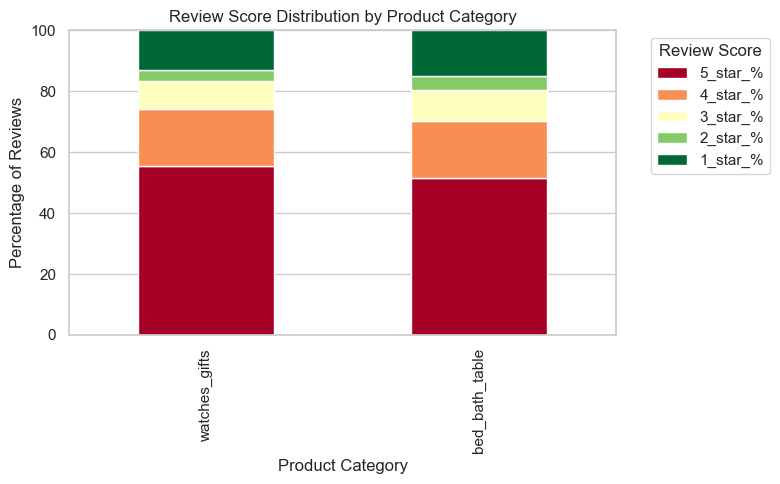

In [108]:
# merge reviews with order_items and product category
review_merged = reviews_db.merge(items_db, on='order_id', how='left') \
                          .merge(prod_db, on='product_id', how='left') \

# group by category
review_by_cat = review_merged.groupby(['product_category_name', 'review_score']) \
                             .size().unstack(fill_value=0)

# total reviews and % breakdown
review_by_cat['total_reviews'] = review_by_cat.sum(axis=1)
review_by_cat['5_star_%'] = (review_by_cat[5] / review_by_cat['total_reviews']) * 100
review_by_cat['4_star_%'] = (review_by_cat[4] / review_by_cat['total_reviews']) * 100
review_by_cat['3_star_%'] = (review_by_cat[3] / review_by_cat['total_reviews']) * 100
review_by_cat['2_star_%'] = (review_by_cat[2] / review_by_cat['total_reviews']) * 100
review_by_cat['1_star_%'] = (review_by_cat[1] / review_by_cat['total_reviews']) * 100

# percentage columns for wg and bb
review_pct = review_by_cat.loc[['watches_gifts', 'bed_bath_table'], 
                               ['5_star_%', '4_star_%', '3_star_%', '2_star_%', '1_star_%']]

# plot
review_pct.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='RdYlGn')

plt.title('Review Score Distribution by Product Category')
plt.ylabel('Percentage of Reviews')
plt.xlabel('Product Category')
plt.legend(title='Review Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 100)
plt.tight_layout()

### Why Watches & Gifts?
Watches & Gifts shows the highest potential among product categories due to its strong revenue performance, high revenue per unit, and better customer satisfaction, with 56% of its reviews being 5-star ratings. While not yet the top in sales volume, if it matched the units sold in leading categories like Health & Beauty, it could surpass all others in total revenue. 

### Why not Bed, Bath, & Table?
Despite high sales volume, it generates lower revenue per unit, indicating limited returns. The category consists of commoditized products with little differentiation, leading to lower profit margins. Additionally, it shows signs of plateauing growth, suggesting a stable but stagnant performance.

# If you were the Chief Marketing Officer, how would you prioritise your (2C) marketing efforts?

If I were the Chief Marketing Officer, I would prioritize my consumer (2C) marketing efforts by focusing on both high-performing and high-potential product categories and locations.

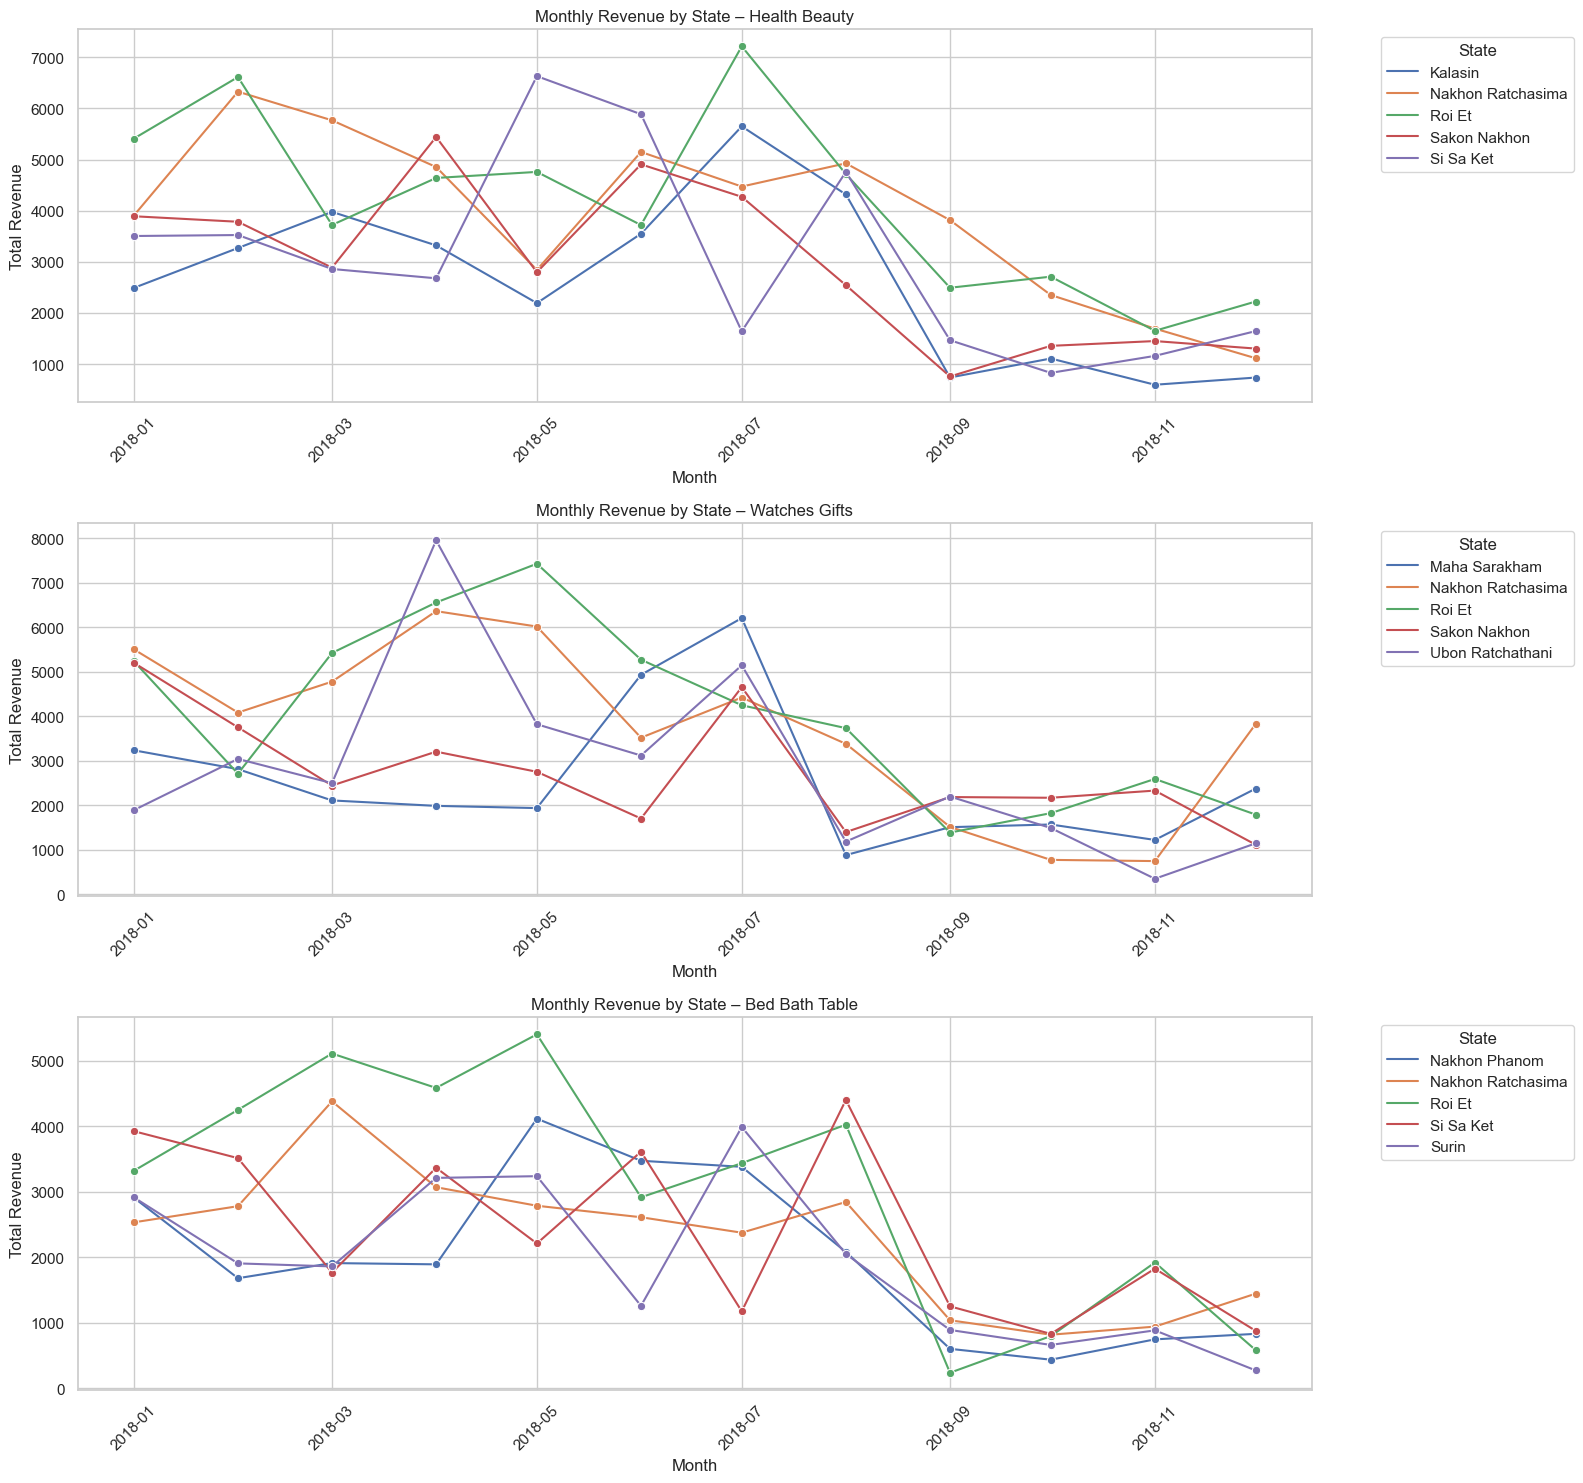

In [109]:
# merge with order date

order_merged_date_df = (
    orders_filtered[['order_id', 'customer_id', 'order_purchase_timestamp']]
    .merge(items_db[['order_id', 'product_id', 'price']], on='order_id', how='left')
    .merge(prod_db[['product_id', 'product_category_name']], on='product_id', how='left')
    .merge(cust_db[['customer_id', 'customer_state']], on='customer_id', how='left')
)

order_merged_date_df['order_month'] = order_merged_date_df['order_purchase_timestamp'].dt.to_period('M')

# filter for target categories
target_cats = ['health_beauty', 'watches_gifts', 'bed_bath_table']
filtered = order_merged_date_df[order_merged_date_df['product_category_name'].isin(target_cats)]

# group by month, state, and category
summary = filtered.groupby(
    ['order_month', 'customer_state', 'product_category_name']
).agg(
    total_orders=('order_id', 'nunique'),
    total_revenue=('price', 'sum')
).reset_index()

# top 5 states per month and category by revenue
top_states = summary.sort_values(
    ['order_month', 'product_category_name', 'total_revenue'],
    ascending=[True, True, False]
).groupby(
    ['order_month', 'product_category_name']
).head(5)


# datetime format
summary['order_month'] = pd.to_datetime(summary['order_month'].astype(str))

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(16, 15))

# loop through each category
for i, category in enumerate(target_cats, 1):
    # filter for category
    cat_df = summary[summary['product_category_name'] == category]

    # top 5 states by total revenue in this category
    top_states = cat_df.groupby('customer_state')['total_revenue'].sum().nlargest(5).index
    cat_df = cat_df[cat_df['customer_state'].isin(top_states)]

    # plot
    plt.subplot(3, 1, i)
    sns.lineplot(
        data=cat_df,
        x='order_month',
        y='total_revenue',
        hue='customer_state',
        marker='o'
    )
    plt.title(f'Monthly Revenue by State – {category.replace("_", " ").title()}')
    plt.xlabel('Month')
    plt.ylabel('Total Revenue')
    plt.xticks(rotation=45)
    plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

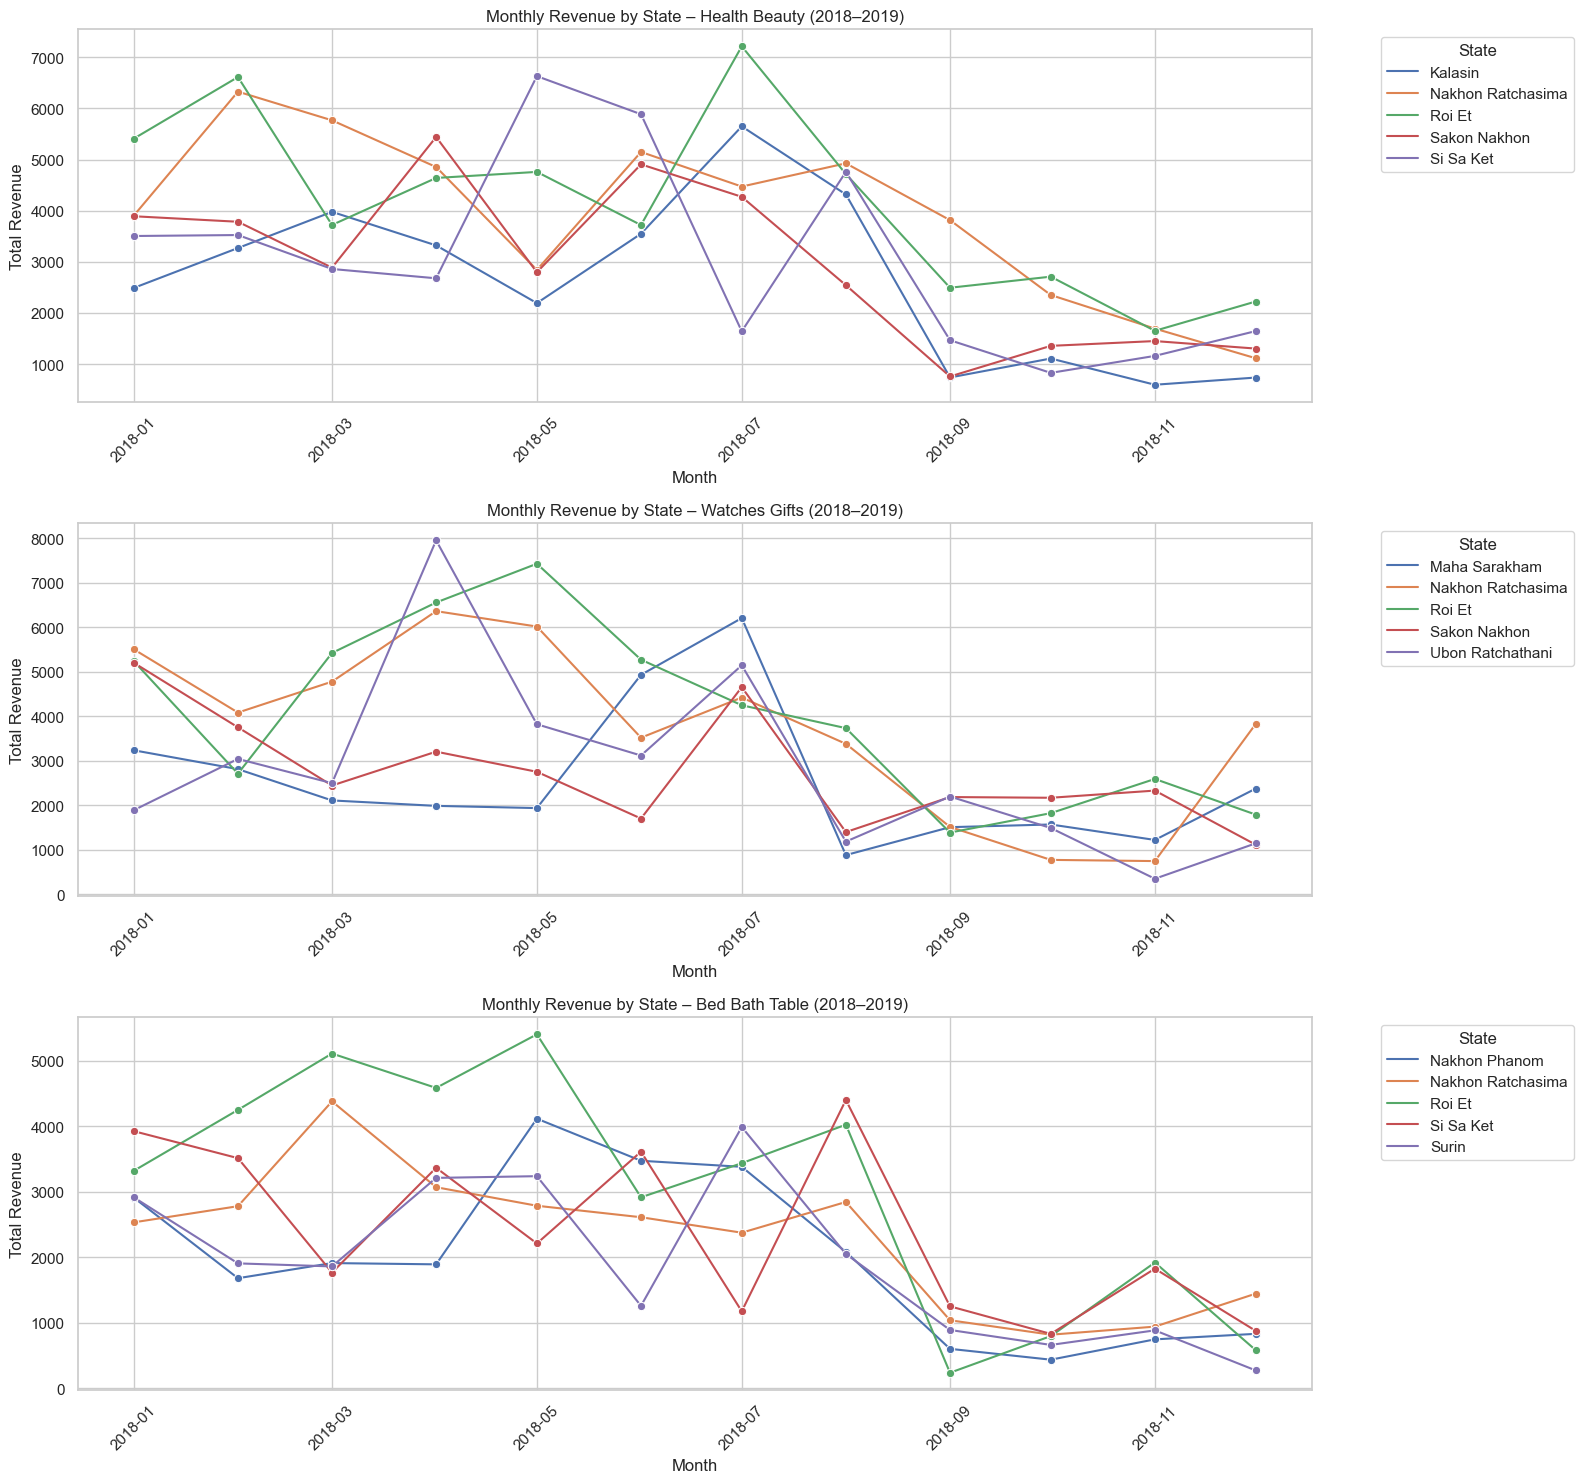

In [110]:
# filter from Jan 2018 to Dec 2019
filtered_df = summary[(summary['order_month'] >= '2018-01-01') & (summary['order_month'] <= '2020-01-01')]

# plot
sns.set(style="whitegrid")
plt.figure(figsize=(16, 15))

# loop over each category
for i, category in enumerate(target_cats, 1):
    cat_df = filtered_df[filtered_df['product_category_name'] == category]
    
    # top 5 states by total revenue in this category
    top_states = cat_df.groupby('customer_state')['total_revenue'].sum().nlargest(5).index
    cat_df = cat_df[cat_df['customer_state'].isin(top_states)]
    
    # plot
    plt.subplot(3, 1, i)
    sns.lineplot(
        data=cat_df,
        x='order_month',
        y='total_revenue',
        hue='customer_state',
        marker='o'
    )
    plt.title(f'Monthly Revenue by State – {category.replace("_", " ").title()} (2018–2019)')
    plt.xlabel('Month')
    plt.ylabel('Total Revenue')
    plt.xticks(rotation=45)
    plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

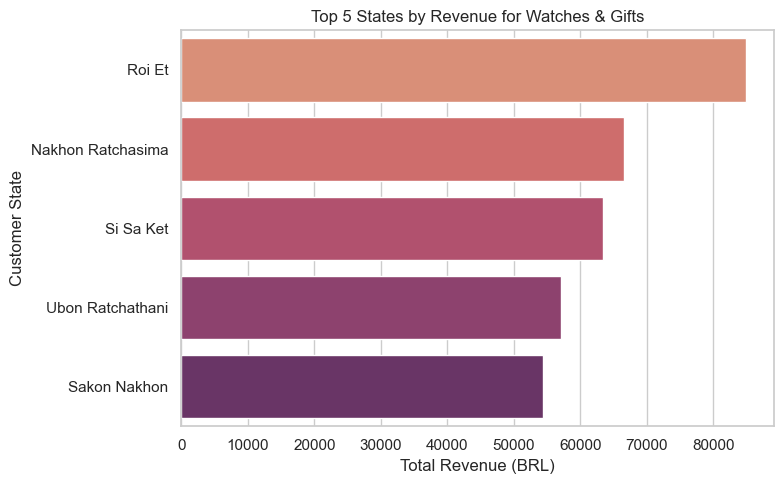

In [111]:
#top locs
orders_db['order_purchase_timestamp'] = pd.to_datetime(orders_db['order_purchase_timestamp'])

# filter for wg
category_df = order_merged_df[order_merged_df['product_category_name'] == 'watches_gifts']

# group by state to get total revenue
revenue_by_state = (
    category_df.groupby('customer_state')['price']
    .sum()
    .reset_index(name='category_revenue')
    .sort_values(by='category_revenue', ascending=False)
)


# top 5 states
top_states = revenue_by_state.head(5)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=top_states, x='category_revenue', y='customer_state', palette='flare')

plt.title('Top 5 States by Revenue for Watches & Gifts')
plt.xlabel('Total Revenue (BRL)')
plt.ylabel('Customer State')
plt.tight_layout()
plt.show()

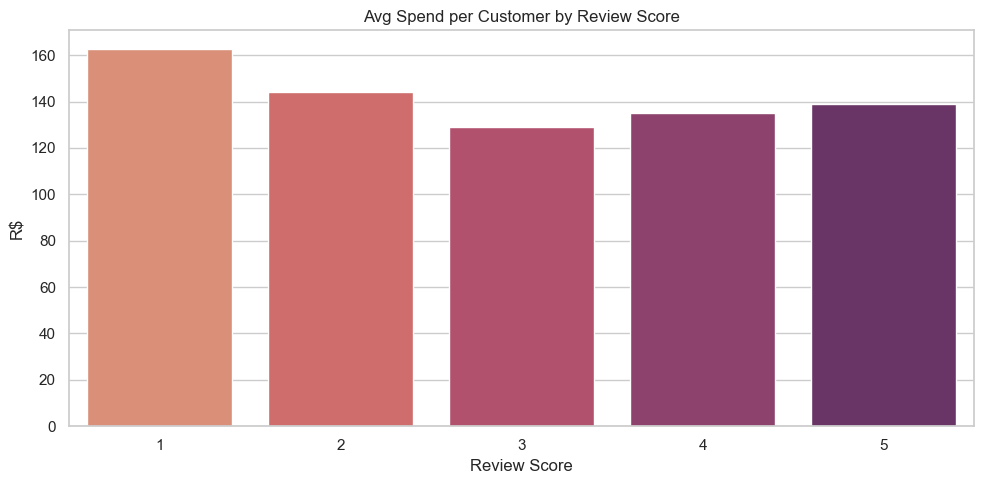

In [112]:
# merge
rev_orders = reviews_db.merge(orders_db[['order_id', 'customer_id']], on='order_id', how='left')
rev_orders_items = rev_orders.merge(items_db[['order_id', 'price', 'product_id']], on='order_id', how='left')
rev_full = rev_orders_items.merge(cust_db[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

# group by review_score and customer for total spent
review_value = rev_full.groupby(['review_score', 'customer_unique_id']).agg(
    total_spent=('price', 'sum')
).reset_index()

# get average spend per review score
score_summary = review_value.groupby('review_score').agg(
    avg_spent_per_customer=('total_spent', 'mean')
).reset_index()

# plot
plt.figure(figsize=(10, 5))
sns.barplot(data=score_summary, x='review_score', y='avg_spent_per_customer', palette="flare")
plt.title("Avg Spend per Customer by Review Score")
plt.ylabel("R$")
plt.xlabel("Review Score")
plt.tight_layout()
plt.show()
